# The given default Classifier (Logistic Regression)

+ colour and greyscale + optimisation of threshold

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
from mask_to_submission import *
import pandas as pd

from sklearn import linear_model
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [2]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [3]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = len(files) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

#n = 40 # Only use 10 images for training

Loading 100 images
satImage_001.png
Loading 100 images
satImage_001.png


In [4]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [5]:
# Extract 6-dimensional features consisting of average RGB color as well as variance
def extract_features(img):
    feat_m = np.mean(img, axis=(0,1))
    feat_v = np.var(img, axis=(0,1))
    feat = np.append(feat_m, feat_v)
    return feat

# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat

def extract_features_all(img):
    feat_m = np.mean(img, axis=(0,1))
    feat_v = np.var(img, axis=(0,1))
    feat_m1 = np.mean(img)
    feat_v1 = np.var(img)
    f = np.append(feat_v, feat_m)
    f1 = np.append(feat_v1, feat_m1)
    feat = np.append(f, f1)
    
    
    return feat

# Extract features for a given image
def extract_img_features(filename):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray([ extract_features_all(img_patches[i]) for i in range(len(img_patches))])
    return X

In [6]:
# Compute features for each image patch
#foreground_threshold = 0.4 # percentage of pixels > 1 required to assign a foreground label to a patch
def value_to_class(v, foreground_threshold):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0
    
def compute_best_f1_for_threshold(threshold):
    
    X = np.asarray([extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
    Y = np.asarray([value_to_class(np.mean(gt_patches[i]),threshold) for i in range(len(gt_patches))])
    
    #Train-Test split
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.20, random_state=42)
    
    # we create an instance of the classifier and fit the data
    classifier = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
    classifier.fit(X_train, y_train)

    #Train-Test split
    k = 40
    f1 = cross_val_score(classifier, X, Y, cv=k, scoring="f1")
    
    return f1.mean()

In [7]:
thresholds = []
scores = []
for i in range(18, 50, 1):
    f1 = compute_best_f1_for_threshold(i/100)
    thresholds.append(i)
    scores.append(f1)

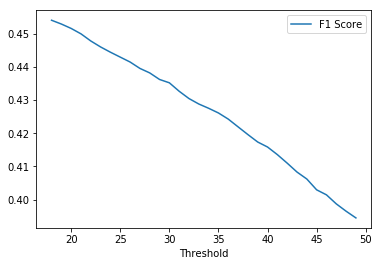

In [8]:
d = {'Threshold': thresholds, 'F1 Score': scores}
df = pd.DataFrame(d)
df.plot(x='Threshold')

In [9]:
df.loc[df['F1 Score'].idxmax()]

Threshold    18.000000
F1 Score      0.454122
Name: 0, dtype: float64

In [10]:
# Print feature statistics

print('Computed ' + str(X.shape[0]) + ' features')
print('Feature dimension = ' + str(X.shape[1]))
print('Number of classes = ' + str(np.max(Y)))  #TODO: fix, length(unique(Y)) 

Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print('Class 0: ' + str(len(Y0)) + ' samples')
print('Class 1: ' + str(len(Y1)) + ' samples')

NameError: name 'X' is not defined

In [ ]:
# Check how well this does (Simple)
y_pred = classifier.predict(X_test)
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('Precision: ', metrics.precision_score(y_test, y_pred))
print('Recall: ', metrics.recall_score(y_test, y_pred))
print('F1 Score: ', metrics.f1_score(y_test, y_pred))

In [ ]:
# Check automatically with crossvalidation
k = 40
precision = cross_val_score(classifier, X, Y, cv=k, scoring="precision")
recall = cross_val_score(classifier, X, Y, cv=k, scoring="recall")
accuracy = cross_val_score(classifier, X, Y, cv=k, scoring="accuracy")
f1 = cross_val_score(classifier, X, Y, cv=k, scoring="f1")


print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy.mean(), accuracy.std() * 2))
# Precision: avoid false positives
print("Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))
# Recall: avoid false negatives
print("Recall: %0.2f (+/- %0.2f)" % (recall.mean(), recall.std() * 2))
print("F1 Score: %0.2f (+/- %0.2f)" % (f1.mean(), f1.std() * 2))

In [ ]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img
    

In [ ]:
#Create prediction images using all the test images
def binary_to_uint8(img):
    rimg = (img * 255).round().astype(np.uint8)
    return rimg

def create_submission(classifier):
    test_img_dir = 'test_set_images/'
    for img_idx in range(1, 51):

        test_img_dir_i = test_img_dir + 'test_' + str(img_idx) + '/'
        test_files = os.listdir(test_img_dir_i)
        img = load_image(test_img_dir_i + test_files[0])

        Xi = extract_img_features(test_img_dir_i + test_files[0])
        Zi = classifier.predict(Xi)
        w = img.shape[0]
        h = img.shape[1]
        predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
        #cimg = concatenate_images(imgs[img_idx], predicted_im)
        Image.fromarray(binary_to_uint8(predicted_im)).save('predictions/prediction_' + '%.3d' % img_idx + '.png')

In [ ]:
create_submission(classifier)
#then launch python3 mask_to_submission.py from terminal